In [1]:
import torch
import torchvision
import torch.nn as nn
import math
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Set random seeds for reproducibility
torch.manual_seed(0)

In [4]:
latent_dim = 256
num_channels = [256, 128, 64, 32, 1]
img_width = 32  # Image dimensions
batch_size = 64
lr_g = 0.00002  # Generator
lr_d = 0.00001  # Discriminator
num_epochs = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),  # Scale to [-1, 1]
    transforms.RandomRotation(10),
])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
class MappingNetwork(nn.Module):
    def __init__(self, latent_dim):
        super(MappingNetwork, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(0, 8):
            self.layers.append(nn.Sequential(
                nn.Linear(latent_dim, latent_dim),
                nn.LeakyReLU(negative_slope=0.2) # Usually, in StyleGan, a larger slope is used for more stability
            ))
            
        # Initialise layers
        for layer in self.layers:
            if isinstance(layer[0], nn.Linear):
                nn.init.kaiming_normal_(layer[0].weight, a=0.2)  # He initialisation
                nn.init.zeros_(layer[0].bias)

    def forward(self, x):
        x = x / x.norm(dim=1, keepdim=True)
        for layer in self.layers:
            x = layer(x)
        return x

In [7]:
class Discriminator(nn.Module):
    def __init__(self, d_conv_channels, img_width=32):
        super(Discriminator, self).__init__()
        self.layers = nn.ModuleList()
        # Add layers
        for i in range(len(d_conv_channels)-1):
            self.layers.append(nn.Sequential(
                nn.Conv2d(d_conv_channels[i], d_conv_channels[i+1], kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(d_conv_channels[i+1]),
                nn.LeakyReLU(negative_slope=0.2)
            ))

        # Calculate the input size for a linear layer
        final_feature_size = img_width // (2 ** (len(d_conv_channels) - 1))

        # After extracting convolutional features, flatten to pass input through the fcn
        self.layers.append(nn.Sequential(
            nn.Flatten(),
            nn.Linear(d_conv_channels[-1]*final_feature_size*final_feature_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1)
        ))
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [8]:
class A(nn.Module):
    def __init__(self, num_input_channels):
        super(A, self).__init__()
        self.layer = nn.Linear(latent_dim, num_input_channels*2)
        self.num_input_channels = num_input_channels
        
    def forward(self, x):
        # print(f"Shape in A is {x.shape}, num input channels {self.num_input_channels}")
        batch_size = x.shape[0]
        out = self.layer(x)
        # print(x.shape, self.layer.shape)
        return out.chunk(2, dim=1) # Half for channel scaling factors, the other half for channels bias. Returns (batch, num_channels), (batch, num_channels)

In [9]:
class B(nn.Module):
    def __init__(self, num_input_channels, img_width):
        super(B, self).__init__()
        # self.noise_scalers = nn.Parameter(torch.ones(num_input_channels, 1, 1))
        self.noise_scalers = nn.Parameter(torch.ones(num_input_channels, 1, 1) * 0.1)
        self.noise_bias = nn.Parameter(torch.ones(num_input_channels, 1, 1) * 0.9)

    def forward(self, x_shape):
        # noise = torch.randn(x_shape, device=self.noise_scalers.device)
        noise = torch.randn(x_shape, device=self.noise_scalers.device) * 0.1
        # print(f"Input shape {x_shape}, {self.noise_scalers.shape}, {self.noise_bias.shape}")
        return noise * self.noise_scalers + self.noise_bias

In [10]:
class AdaIN(nn.Module):
    def __init__(self):
        super(AdaIN, self).__init__()
        
    def forward(self, x, s, b):
        """
        Args:
            x: torch.Tensor shape (batch, num_channels, img_width, img_width)
            s: torch.Tensor shape (batch, num_channels)
            b: torch.Tensor shape (batch_num_channels)
        """
        # First carry out instance normalisation for each layer
        mean = x.mean(dim=[2, 3], keepdim=True) # Shape (batch, num_channels, 1, 1)
        variance = x.var(dim=[2, 3], keepdim=True) # Shape (batch, num_channels, 1, 1)
        x_norm = (x - mean) / torch.sqrt(variance + 1e-5) # instance normalisation, but for each channel

        # Reshape s and b for broadcasting, then scale using s and add bias using b
        s, b = s[:, :, None, None], b[:, :, None, None]
        out = s * x_norm + b
        return out

In [11]:
class UpsamplingBlock(nn.Module):
    def __init__(self, input_channels, output_channels, upsample=True):
        super(UpsamplingBlock, self).__init__()
        self.upsample = upsample
        self.input_channels = input_channels
        self.output_channels = output_channels

        # Initialise one A block for each AdaIN layer
        self.A1 = A(input_channels) if not self.upsample else A(output_channels)
        self.A2 = A(output_channels)

        # Initialise two B blocks for each UpsamplingBlock
        self.B1 = B(input_channels, img_width) if not self.upsample else B(output_channels, img_width)
        self.B2 = B(output_channels, img_width)

        # Initialise layers for this block
        # No upsampling for the first layer
        if upsample: # Not the first block
            self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        # Conv1 only exists in subsequent upsampling blocks
        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=1, padding=1) if self.upsample else nn.Identity()
        self.adain1 = AdaIN()
        self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, stride=1, padding=1) if self.upsample else nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=1, padding=1)
        self.adain2 = AdaIN()

        # Activation function
        self.leakyrelu = nn.LeakyReLU(0.2)
    
    def forward(self, x, w):
        # print(f"Original x shape now is {x.shape}, input channels {self.input_channels}, output channels {self.output_channels}")
        # Upsample first
        if self.upsample:
            x = self.upsample(x)

        # print(f"Shape of x before conv is {x.shape}")
        # Begin the first convolutional block
        x = self.leakyrelu(self.conv1(x))
        b1_out = self.B1(x.shape)
        # print(f"x shape is {x.shape}, b1 shape is {b1_out.shape}")
        x = x + b1_out
        s, b = self.A1(w) # Obtain scaling parameters used by AdaIN
        x = self.adain1(x, s, b) # Use AdaIN for normalisation

        # Begin the last convolutional block
        x = self.leakyrelu(self.conv2(x))
        b2_out = self.B2(x.shape)
        # print(f"x shape is {x.shape}, b2 shape is {b2_out.shape}")
        x = x + b2_out
        s, b = self.A2(w) # Obtain scaling parameters used by AdaIN
        x = self.adain2(x, s, b) # Use AdaIN for normalisation
        # print("done")
        return x

In [12]:
class Generator(nn.Module):
    def __init__(self, num_channels, spatial_sizes):
        super(Generator, self).__init__()
        # self.constant = nn.Parameter(torch.ones(1, num_channels[0], spatial_sizes[0], spatial_sizes[0]))
        self.constant = nn.Parameter(torch.randn(1, num_channels[0], spatial_sizes[0], spatial_sizes[0]))
        self.blocks = nn.ModuleList()

        # Add progressively changing upsampling blocks
        for i in range(len(num_channels) - 1):
            self.blocks.append(
                UpsamplingBlock(num_channels[i], num_channels[i + 1], upsample=(i > 0))  # First block doesn't upsample
            )

    def forward(self, w):
        batch_size = w.shape[0]
        x = self.constant.expand(batch_size, -1, -1, -1)
        for block in self.blocks:
            x = block(x, w)
        return x

In [13]:
# Initialise generator
spatial_sizes = [4, 8, 16, 28]
generator = Generator(num_channels, spatial_sizes)

# Create random latent vector and noise tensors
w = torch.randn(batch_size, latent_dim)  # Latent vector

# Forward pass
output = generator(w)

# Print the output shape
print("Output shape:", output.shape)

Output shape: torch.Size([64, 1, 32, 32])


Epoch [1/3], Step [0/938], D Loss: 1.4078, G Loss: 0.8282
Epoch [1/3], Step [100/938], D Loss: 1.3811, G Loss: 0.8341
Epoch [1/3], Step [200/938], D Loss: 1.3816, G Loss: 0.8274
Epoch [1/3], Step [300/938], D Loss: 1.3648, G Loss: 0.8208
Epoch [1/3], Step [400/938], D Loss: 1.3555, G Loss: 0.8190
Epoch [1/3], Step [500/938], D Loss: 1.3449, G Loss: 0.8173
Epoch [1/3], Step [600/938], D Loss: 1.3462, G Loss: 0.8151
Epoch [1/3], Step [700/938], D Loss: 1.3223, G Loss: 0.8225
Epoch [1/3], Step [800/938], D Loss: 1.3257, G Loss: 0.8178
Epoch [1/3], Step [900/938], D Loss: 1.3330, G Loss: 0.8096


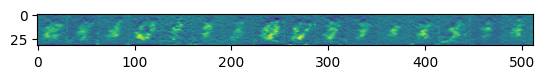

Epoch [2/3], Step [0/938], D Loss: 1.3109, G Loss: 0.8157
Epoch [2/3], Step [100/938], D Loss: 1.3050, G Loss: 0.8171
Epoch [2/3], Step [200/938], D Loss: 1.3063, G Loss: 0.8234
Epoch [2/3], Step [300/938], D Loss: 1.3159, G Loss: 0.8137
Epoch [2/3], Step [400/938], D Loss: 1.3135, G Loss: 0.8274
Epoch [2/3], Step [500/938], D Loss: 1.2927, G Loss: 0.8192


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

# Model Initialisation
generator = Generator(num_channels=num_channels, spatial_sizes=[4, 8, 16, 28]).to(device)
mapping_network = MappingNetwork(latent_dim).to(device)
discriminator = Discriminator(d_conv_channels=[1, 32, 64, 128, 256], img_width=img_width).to(device)

# Loss Function
adversarial_loss = nn.BCEWithLogitsLoss()  # For discriminator and generator

# Optimisers
optimizer_g = optim.Adam(list(generator.parameters()) + list(mapping_network.parameters()), lr=lr_g, betas=(0.5, 0.999))
# optimizer_g = optim.SGD(list(generator.parameters()) + list(mapping_network.parameters()), lr=lr_g)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

# Training Loop
for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        # Sample latent vectors and noise
        batch_size = real_imgs.size(0)
        z = torch.randn(batch_size, latent_dim).to(device)  # Latent vector

        # Generate fake images
        w = mapping_network(z)
        fake_imgs = generator(w)
        # print(fake_imgs.shape)
        # print("Fake shape above")

        # Labels
        # real_labels = torch.ones(batch_size, 1).to(device)
        real_labels = torch.full((batch_size, 1), 0.9, device=device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Discriminator loss
        real_loss = adversarial_loss(discriminator(real_imgs), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # -----------------
        # Train Generator
        # -----------------
        fake_loss_g = adversarial_loss(discriminator(fake_imgs), real_labels)
        g_loss = fake_loss_g

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        # Logging
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # Save some sample images every epoch
    with torch.no_grad():
        z = torch.randn(16, latent_dim).to(device)
        w = mapping_network(z)
        fake_imgs = generator(w).cpu()
        grid = torch.cat([fake_imgs[i] for i in range(16)], dim=2)
        plt.imshow(grid.permute(1, 2, 0).squeeze(2).detach().numpy())
        plt.show()